In [129]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os

from parser import parse_filename, natural_sort
import pandas as pd

In [198]:
nicknames = ['vpp']
files = []
for nickname in nicknames:
    files += glob("/data/wanglei/hydrogen/"+nickname+"/n_*_dim_3_rs_1.4*_T_1500*spsize_*tpsize_*mcsteps_*lr_*/data.txt")
files = list(filter(lambda f: os.path.getsize(f)!=0, files))
files = natural_sort(files)
len(files)

2

/data/wanglei/hydrogen/vpp/n_14_dim_3_rs_1.4_T_1500_steps_1_depth_2_spsize_32_tpsize_16_Nf_5_Gmax_15_kappa_10_mctherm_10_mcsteps_50_mcstddev_0.05_lr_0.001_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/data.txt 3 1.4 1500.0 1 2 32 16 1024 1 0.001 0.001 0.001
/data/wanglei/hydrogen/vpp/n_14_dim_3_rs_1.4_T_1500_steps_1_depth_2_spsize_32_tpsize_16_Nf_5_Gmax_15_kappa_10_mctherm_10_mcsteps_50_mcstddev_0.05_lr_0.01_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/data.txt 3 1.4 1500.0 1 2 32 16 1024 1 0.01 0.001 0.001


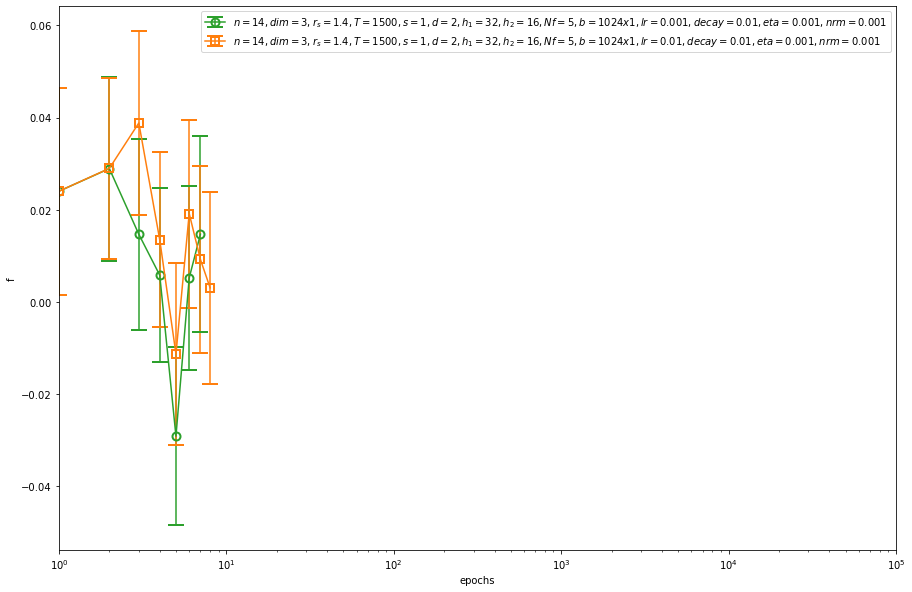

In [199]:
obs = 'f'

markers = ['o', 's', 'D', '*', 'x', '^', '<', 'h', '>', 'd', 'X', 'v', 'h', '1']
colors = ['C2', 'C1','C0', 'C3', 'C4', 'C6', 'C5', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13']

plt.figure(figsize=(15,10))
for f, marker, color in zip(files, markers, colors):
    n, dim, rs, T, s, d, h1, h2, b, a, lr, decay, eta, maxnorm, Nf = parse_filename(f)
    print  (f, dim, rs, T, s, d, h1, h2, b, a, lr, eta, maxnorm)
    df = pd.read_csv(f, delimiter=r"\s+")
    label = r'$n=%s,dim=%s,r_s=%s,T=%g,s=%s,d=%s,h_1=%s,h_2=%s,Nf=%s,b=%sx%s,lr=%s,decay=%s,eta=%s,nrm=%s$'\
                %(n,dim,rs,T,s,d,h1,h2,Nf,b,a,lr,decay,eta,maxnorm)
    
    if obs == 'v':
        y = df['vpp'].values + df['vep'].values + df['vee'].values
        yerr = np.sqrt(df['vpp_err'].values**2 + df['vep_err'].values**2 + df['vee_err'].values**2)
    else:
        y, yerr = df[obs].values, df[obs+'_err'].values
        
    plt.errorbar(df['epoch'].values, y, yerr=yerr,
                 marker=marker, color=color,markerfacecolor='none', 
                 markeredgewidth=2, ms=8, capsize=8, label=label)

    
plt.legend(loc='best')
plt.ylabel(obs)
plt.xlabel('epochs')
#plt.ylim([6.8, 7])
#plt.ylim([-0.16, -0.10])
plt.xlim([1, 1e5])
plt.xscale('log') 